<div style="background-color: #04D7FD; padding: 20px; text-align: left;">
    <h1 style="color: #000000; font-size: 30px; margin: 0;">data-prep-kit planning agent</h1>   
</div>

In [ ]:
%pip install -qq -r requirements.txt

In [1]:
from IPython.display import HTML
task = "Process the provided PDF dataset to identify and extract only documents that don't contain inappropriate language. Remove the duplications."
HTML(f"<p><span style='color:blue; font-weight:bold; font-size:14.0pt;'>TASK: {task}</span></p>")

In [2]:
import logging
import os

from llm_utils.logging import prep_loggers
os.environ["LLM_LOG_PATH"] = "./logs/llm_log.txt"
prep_loggers("llm=INFO")

0

In [3]:
from llm_utils.dpk.tools import *
print(tools_json)


[
    {"name": "exact_dedup", "description": "Exact data deduplication is used to identify (and remove) redundant records.",
        "input": [{"name": "in_folder", "description": "input directory to transform files from.", "type": "str"},
            {"name": "out_folder", "description": "destination directory to store the transformed files.", "type": "str"}],
        "import": "from llm_utils.dpk.langchain_tools.tools.universal.ededup import EdedupTransform"},

    {"name": "Pdf2Parquet", "description": "The Pdf2Parquet transform generates parquet files containing the converted document.",
        "input": [{"name": "in_folder", "description": "input directory to transform files from.", "type": "str"},
            {"name": "out_folder", "description": "destination directory to store the transformed files.", "type": "str"},
            {"name": "data_files_to_use", "description": "files extentions to transform.", "type": "list"}],
        "import": "from llm_utils.dpk.langchain_tools

In [4]:
from llm_utils.dpk.examples import *
print(example_task)


For example, If the required task was Filter the parquet files to include only english documents. The the plan should be the following:
{"step_name": "Step #1 language identification", "tool_name": "language_id", "tool_input": [{"in_folder": "user_input", "out_folder": "user_input"}], "step_ev": "Ev1"}
{"step_name": "Step #2 filter english documents", "tool_name": "filter_transform", "tool_input": [{"in_folder": "#Ev1"}, {"out_folder": "user_input"}, {"filter_criteria_list": [lang==en]}], "step_ev": "Ev2"}



In [5]:
from llm_utils.dpk.constraints import *
print(constraints)

constraint: If the 'exact_dedup' tool is needed then it must run as the first step or immediately after 'Pdf2Parquet'.
constraint: If the 'tokenization' transform is needed then it must run as the last transform of the plan. Otherwise, it should not be part of the plan.
constraint: run 'Pdf2Parquet' tool as a first step if the input is pdf files.



In [6]:
from llm_utils.models import getChatLLM
from dotenv import dotenv_values

config = dotenv_values("./.env")
model_id1 = "ibm-granite/granite-3.1-8b-instruct"
model_id2 = "meta-llama/llama-3-1-70b-instruct"
model_id3 = "mistralai/mixtral-8x7B-instruct-v0.1"
model_id4 = "ibm/granite-34b-code-instruct"

llm_plan = getChatLLM("watsonx", model_id2, config)
llm_judge = getChatLLM("watsonx", model_id2, config)
llm_generate = getChatLLM("watsonx", model_id2, config)

In [7]:
from langgraph.graph import StateGraph, END
from llm_utils.agent_helpers import *
from llm_utils.prompts.planner_prompt import *
from llm_utils.prompts.judge_prompt import *
from llm_utils.prompts.generate_prompt import *
from llm_utils.dpk.tools import *
from llm_utils.dpk.examples import *
from llm_utils.dpk.constraints import *
from functools import partial


# Create the graph
workflow = StateGraph(State)

# Add nodes
workflow.add_node("planner", partial(planner, prompt=planner_prompt_str, tools=tools_json, example=example_task1, context=constraints, llm=llm_plan))
workflow.add_node("judge", partial(judge, prompt=judge_prompt_str_dpk, tools=tools_json, context=constraints, llm=llm_judge))
workflow.add_node("user_review", get_user_review)
workflow.add_node("code generator", partial(generator, prompt=generate_prompt_str_with_example, llm=llm_generate))
workflow.add_node("code validator", code_validator)

# Add edges
# workflow.add_edge("planner", "judge")
workflow.set_entry_point("planner")
workflow.add_edge("code generator", "code validator")
workflow.add_edge("code validator", END)

# Add conditional edges from judge
workflow.add_conditional_edges(
    "judge",
    is_plan_OK,
    {
        False: "planner",  # If needs revision, go back to planner
        True: "user_review"  # If plan is good, proceed to user review
    }
)

# Add conditional edges from planner
workflow.add_conditional_edges(
    "planner",
    need_judge,
    {
        True: "judge",  # If needs revision, go back to planner
        False: "user_review"  # If plan is good, proceed to user review
    }
)

workflow.add_conditional_edges(
    "user_review",
    is_user_review_OK,
    {
        False: "planner",  # If needs revision, go back to planner
        True: "code generator",
    }
)


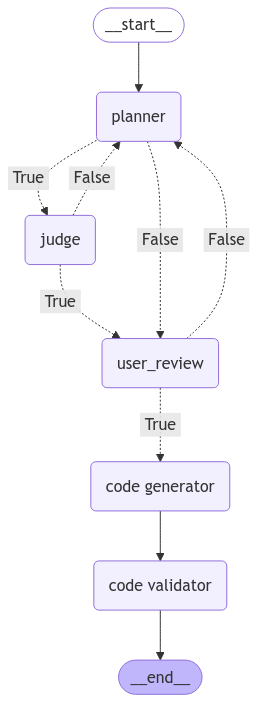

In [8]:
app = workflow.compile()

from IPython.display import Image, display

#display(Image(app.get_graph(xray=True).draw_mermaid_png()))
display(Image(app.get_graph().draw_mermaid_png()))

In [ ]:
# Run the graph
initial_state = {
    "task": task,
    "context": "",
    "plan": ["still no plan"],
    "planning_attempts": 0,
    "feedback": "Still no review",
    "needs_revision": "",
    "need_judge": True,
}

state = initial_state

for output in app.stream(state):
    pass


Planner: suggested plan is:
 I will generate a plan to accomplish the task: Process the provided PDF dataset to identify and extract only documents that don't contain inappropriate language. Remove the duplications.
Here is the plan: 
{"step_name": "Step #1 convert pdf to parquet", "tool_name": "Pdf2Parquet", "tool_input": [{"in_folder": "user_input", "out_folder": "user_input", "data_files_to_use": "['pdf']"}], "import": "from llm_utils.dpk.langchain_tools.tools.language.pdf2parquet import Pdf2parquetTransform", "step_ev": "#E1"}
{"step_name": "Step #2 remove duplicates", "tool_name": "exact_dedup", "tool_input": [{"in_folder": "#E1", "out_folder": "#E1"}], "import": "from llm_utils.dpk.langchain_tools.tools.universal.ededup import EdedupTransform", "step_ev": "#E2"}
{"step_name": "Step #3 calculate document quality", "tool_name": "doc_quality", "tool_input": [{"in_folder": "#E2", "out_folder": "#E2", "docq_bad_word_filepath": "user_input"}], "import": "from llm_utils.dpk.langchain_t

```mermaid
graph LR;
    step0["Pdf2Parquet"]
    step0 --> step1
    step1["exact_dedup"]
    step1 --> step2
    step2["doc_quality"]
    step2 --> step3
    step3["filter_transform"]
    step3 --> step4
    step4["tokenization"]
```


Judge: review:
1. The plan is valid and properly addresses the task requirements according to the given tools.
2. The plan satisfies all constraints. 
3. No unnecessary transforms are found.

NEEDS_REVISION: No



Please review the plan and provide feedback (or print 'okay', 'OK' or just Enter to continue):  please remove the tpkenization step



Planner: suggested plan is:
 I will generate a plan to accomplish the task: Process the provided PDF dataset to identify and extract only documents that don't contain inappropriate language. Remove the duplications.
Here is the plan: 
{"step_name": "Step #1 convert pdf to parquet", "tool_name": "Pdf2Parquet", "tool_input": [{"in_folder": "user_input", "out_folder": "user_input", "data_files_to_use": "['pdf']"}], "import": "from llm_utils.dpk.langchain_tools.tools.language.pdf2parquet import Pdf2parquetTransform", "step_ev": "#E1"}
{"step_name": "Step #2 remove duplicates", "tool_name": "exact_dedup", "tool_input": [{"in_folder": "#E1", "out_folder": "#E1"}], "import": "from llm_utils.dpk.langchain_tools.tools.universal.ededup import EdedupTransform", "step_ev": "#E2"}
{"step_name": "Step #3 calculate document quality", "tool_name": "doc_quality", "tool_input": [{"in_folder": "#E2", "out_folder": "#E2", "docq_bad_word_filepath": "user_input"}], "import": "from llm_utils.dpk.langchain_t

```mermaid
graph LR;
    step0["Pdf2Parquet"]
    step0 --> step1
    step1["exact_dedup"]
    step1 --> step2
    step2["doc_quality"]
    step2 --> step3
    step3["filter_transform"]
```